# ENGSCI 712 HAR Assignment

## Introduction

This experiment aims to classify walking and running activites by extracting relevant features from time-series data, and fitting a Random Forest Classifier to these features. 

## Experiment 
The linear acceleration in the x, y and z directions and the total acceleration of the subject was recorded using the 'Physics Toolbox' app on an iPhone 15 Pro. 

The experiment was conducted over 6 different speeds on a treadmill, and were labelled as either walking or running: 
- Walking: 2 km/h, 3 km/h, 4 km/h.
- Running: 8 km/h, 10 km/h, 12 km/h.

Each sample was recorded over approximately three minutes, with the iPhone held in the subject’s right hand. A standard running technique was used, with the arms positioned roughly perpendicular to the ground, swinging back and forth. Similarly, the walking technique followed a typical form, with the arms relaxed by the sides and swinging naturally back and forth.


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tsfresh.transformers import FeatureSelector
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedKFold
from pathlib import Path

warnings.filterwarnings(action='ignore')

%matplotlib inline

### Directory Paths

In [72]:
data_dir = Path('..') / 'data'
fig_dir = Path('..') / 'reports' / 'figures'
model_dir = Path('..') / 'models'

## Loading the Raw Data

In [73]:
two_kmph_df = pd.read_csv('../data/raw/acceleration-2kmph-walking.csv', index_col='time')
three_kmph_df = pd.read_csv('../data/raw/acceleration-3kmph-walking.csv', index_col='time')
four_kmph_df = pd.read_csv('../data/raw/acceleration-4kmph-walking.csv', index_col='time')
eight_kmph_df = pd.read_csv('../data/raw/acceleration-8kmph-running.csv', index_col='time')
ten_kmph_df = pd.read_csv('../data/raw/acceleration-10kmph-running.csv', index_col='time')
twelve_kmph_df = pd.read_csv('../data/raw/acceleration-12kmph-running.csv', index_col='time')


In [74]:
two_kmph_df.head()

ax    ay    az  atotal
time                          
0.00  0.22 -0.54  0.48    0.75
0.01 -0.07 -0.72  0.23    0.76
0.02 -0.46 -0.75 -0.32    0.94
0.03 -0.77 -0.61 -0.47    1.09
0.04 -0.79 -0.44 -0.36    0.97

## Visualisation of Raw Data

### Comparison of acceleration in the x-direction

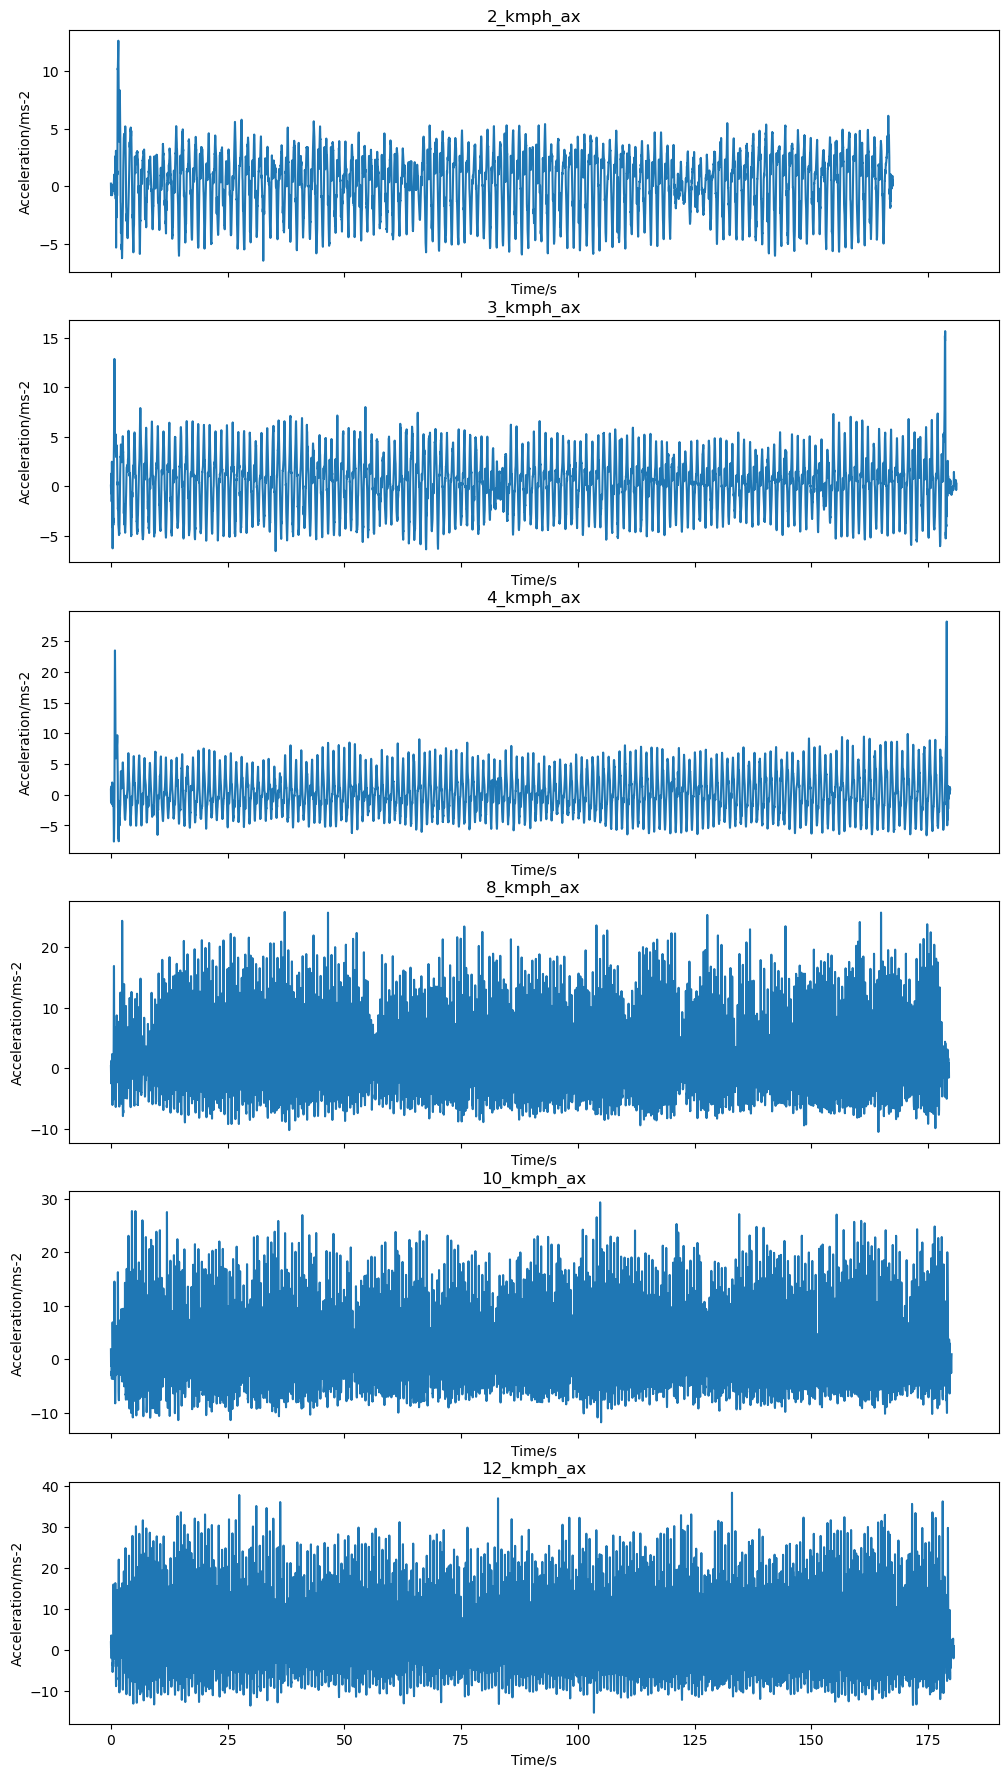

In [75]:
all_speeds = [two_kmph_df, three_kmph_df, four_kmph_df, eight_kmph_df, ten_kmph_df, twelve_kmph_df] # List of all samples.
all_names = ['2_kmph', '3_kmph', '4_kmph', '8_kmph', '10_kmph', '12_kmph']
column_labels = two_kmph_df.columns

fig_ax, ax_x = plt.subplots(6, sharex=True)
fig_ax.set_figwidth(12)
fig_ax.set_figheight(22)

for i in range(len(ax_x)):
    ax_x[i].set_title(f'{all_names[i]}_ax')
    ax_x[i].set_xlabel('Time/s')
    ax_x[i].set_ylabel('Acceleration/ms-2')
    ax_x[i].plot(all_speeds[i].index, all_speeds[i]['ax'])

plt.savefig(fig_dir / 'ax_raw_fig.png')
plt.show()


### Comparison of acceleration in the y-direction

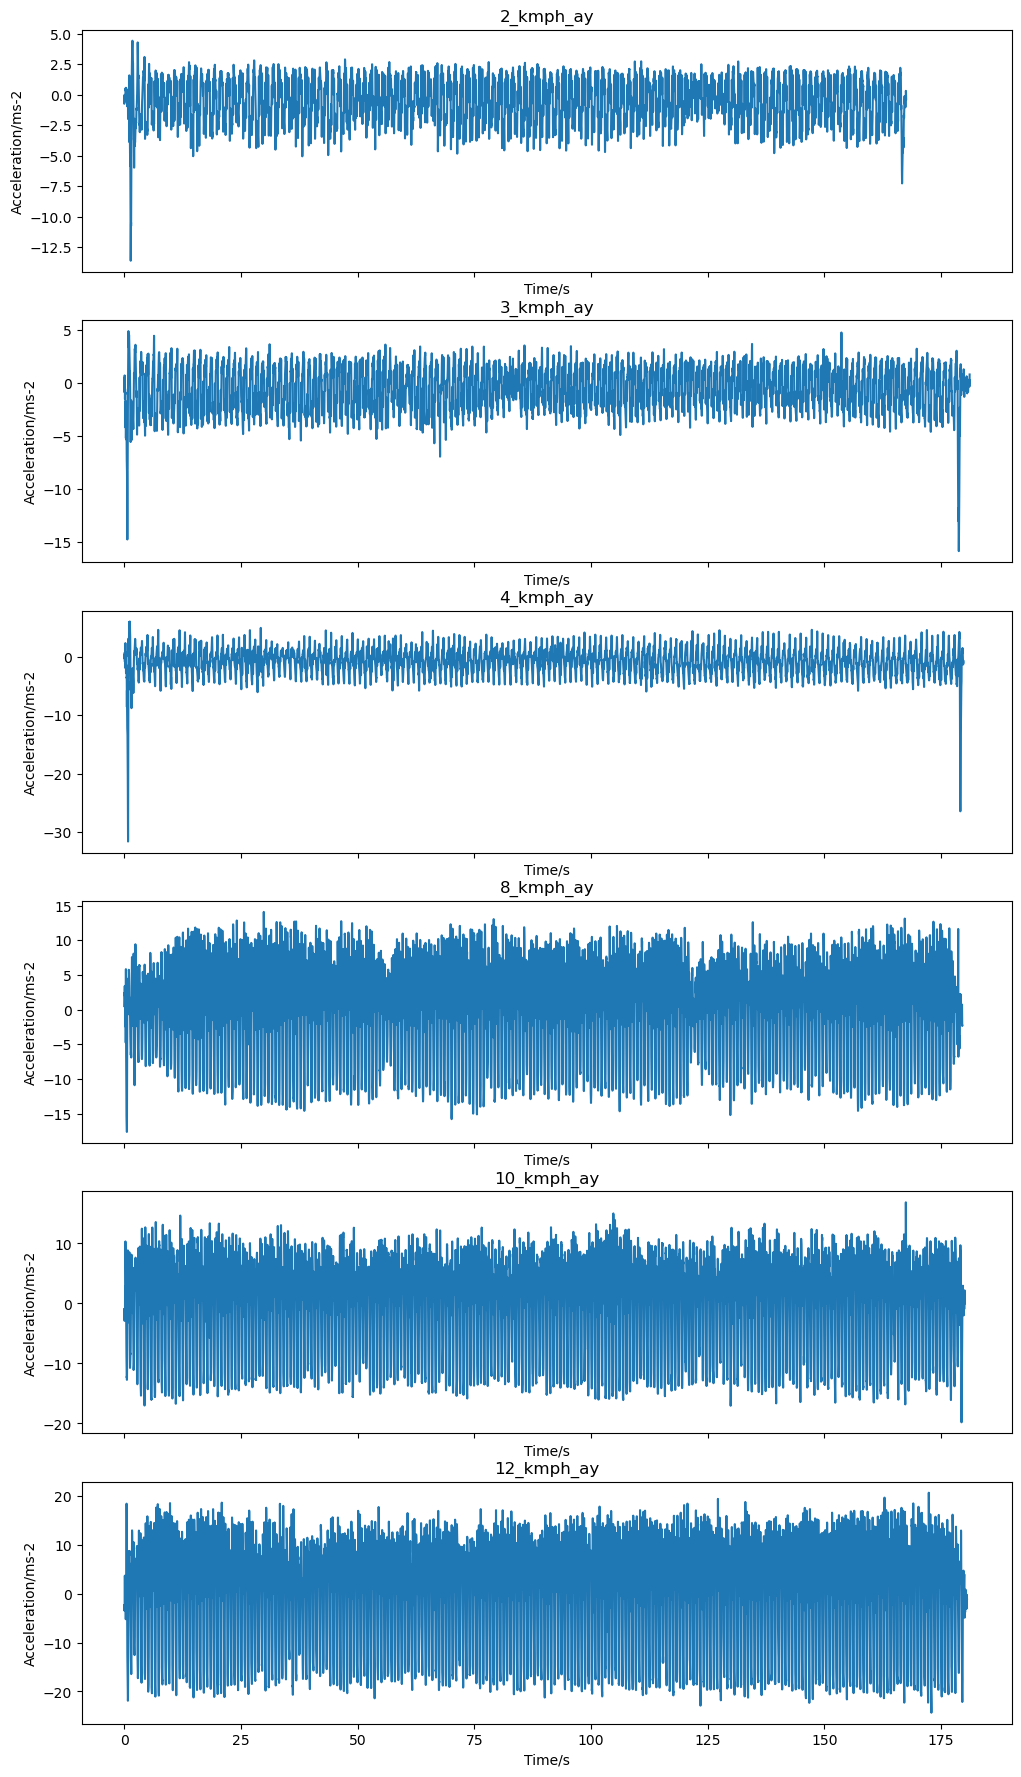

In [76]:
fig_ay, ax_y = plt.subplots(6, sharex=True)
fig_ay.set_figwidth(12)
fig_ay.set_figheight(22)

for i in range(len(ax_y)):
    ax_y[i].set_title(f'{all_names[i]}_ay')
    ax_y[i].set_xlabel('Time/s')
    ax_y[i].set_ylabel('Acceleration/ms-2')
    ax_y[i].plot(all_speeds[i].index, all_speeds[i]['ay'])
    
plt.savefig(fig_dir / 'ay_raw_fig.png')
plt.show()

### Comparison of acceleration in the z-direction

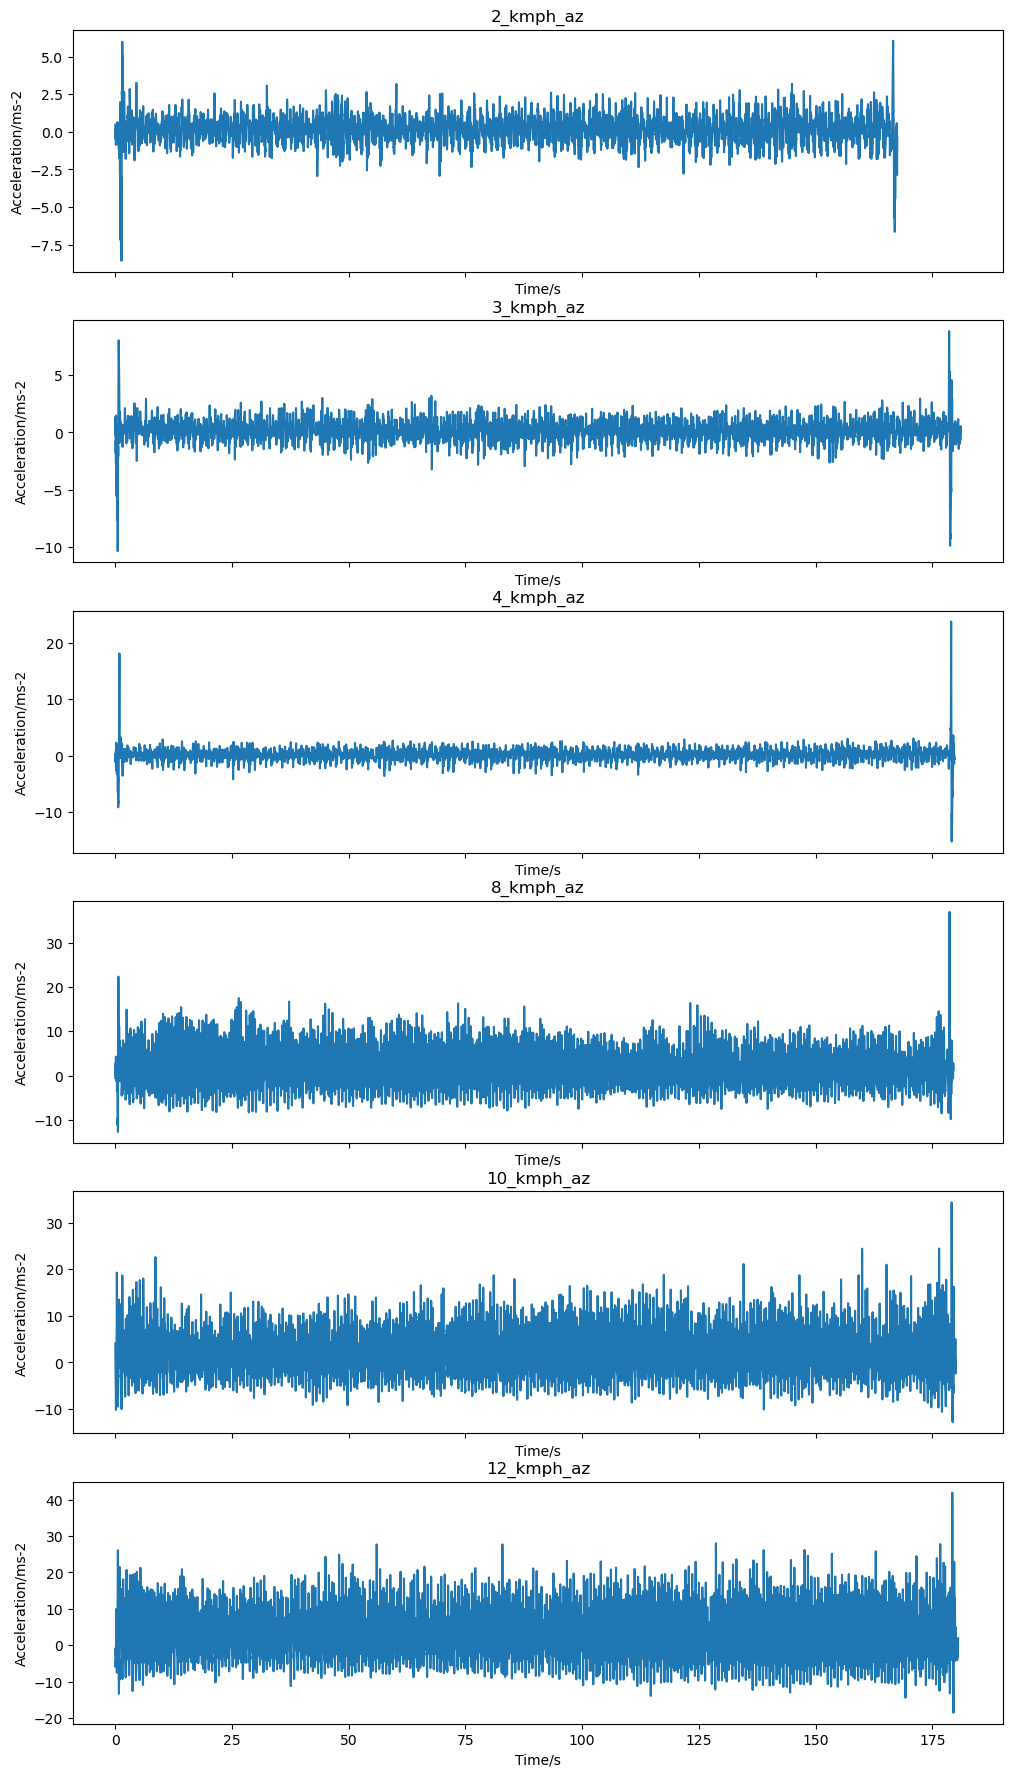

In [77]:
fig_az, ax_z = plt.subplots(6, sharex=True)
fig_az.set_figwidth(12)
fig_az.set_figheight(22)

for i in range(len(ax_z)):
    ax_z[i].set_title(f'{all_names[i]}_az')
    ax_z[i].set_xlabel('Time/s')
    ax_z[i].set_ylabel('Acceleration/ms-2')
    ax_z[i].plot(all_speeds[i].index, all_speeds[i]['az'])
        
plt.savefig(fig_dir / 'az_raw_fig.png')
plt.show()

### Comparison of total acceleration

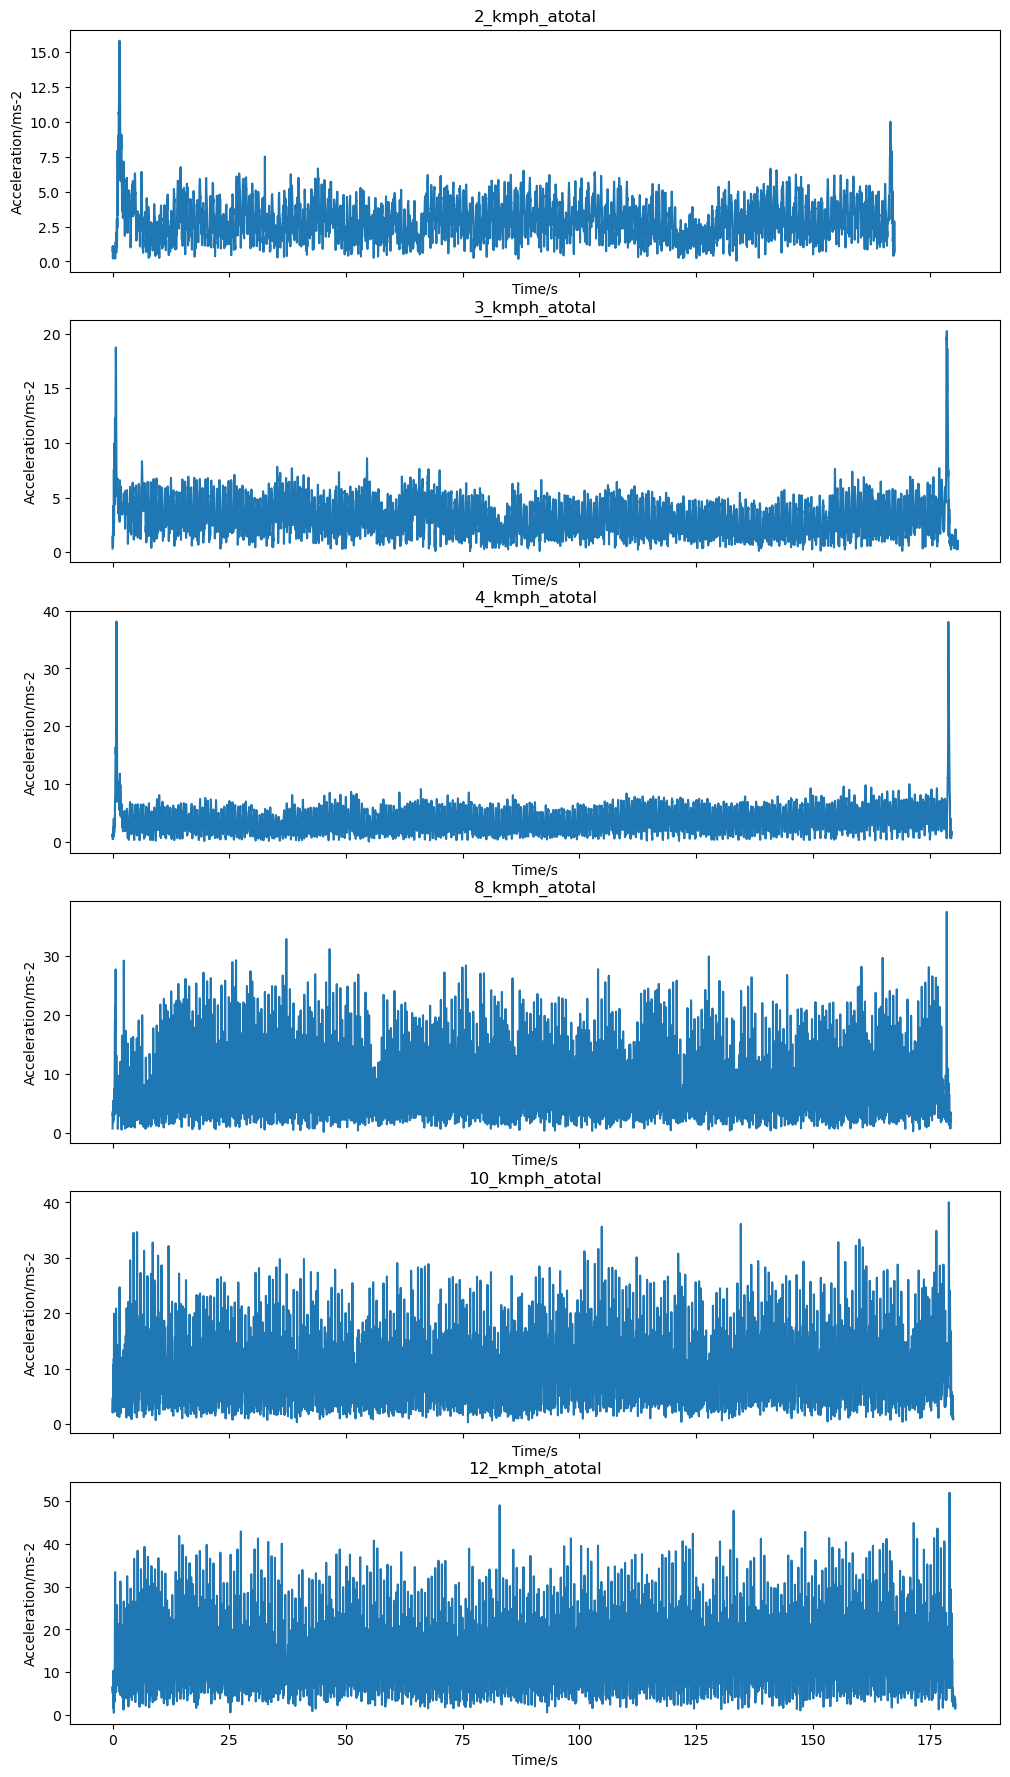

In [78]:
fig_atotal, ax_total = plt.subplots(6, sharex=True)
fig_atotal.set_figwidth(12)
fig_atotal.set_figheight(22)

for i in range(len(ax_total)):
    ax_total[i].set_title(f'{all_names[i]}_atotal')
    ax_total[i].set_xlabel('Time/s')
    ax_total[i].set_ylabel('Acceleration/ms-2')
    ax_total[i].plot(all_speeds[i].index, all_speeds[i]['atotal'])

plt.savefig(fig_dir / 'atotal_raw_fig.png')
plt.show()

### Observations
There is a general increase in the amplitude and frequency of the signals as the speed of the activity increases. This is expected because a faster walk/run would result in faster swinging of the arms.

The duration of each sample was defined by noticeable spikes in signal amplitude at both the beginning and end, particularly in the z-direction. These sudden movements were intentionally introduced at the start and end of each walking or running activity to clearly mark the sample boundaries.

## Preprocessing

The raw data time column was already formatted as a 'delta_t" column so creating this column was not necessary.

### Removal of transition periods

The transitions periods were found by searching through the dataframes, and removing the outlier observations at the start and end.

In [79]:
pruned_two_kmph_df = two_kmph_df[(two_kmph_df.index >= 1.949) & (two_kmph_df.index <= 166.494)] # Pruning
pruned_two_kmph_df.index -= pruned_two_kmph_df.index[0] # Resetting index to start at time = 0.000
pruned_two_kmph_df

ax    ay    az  atotal
time                             
0.000    6.04  0.33  1.03    6.14
0.010    5.76 -0.20  0.97    5.84
0.020    5.57 -0.44  1.10    5.69
0.030    5.37 -0.93  0.93    5.53
0.040    5.07 -1.66  0.79    5.39
...       ...   ...   ...     ...
164.505  4.82 -1.04  1.53    5.17
164.515  4.89 -1.50  1.84    5.44
164.525  5.22 -2.11  1.97    5.97
164.535  5.60 -2.39  2.15    6.45
164.545  5.92 -2.66  2.41    6.92

[16463 rows x 4 columns]

In [80]:
pruned_three_kmph_df = three_kmph_df[(three_kmph_df.index >= 0.880) & (three_kmph_df.index <= 178.542)]
pruned_three_kmph_df.index -= pruned_three_kmph_df.index[0]
pruned_three_kmph_df

ax    ay    az  atotal
time                             
0.000    4.10  3.34  2.50    5.85
0.010    4.29  4.09  1.73    6.18
0.020    4.37  4.65  0.98    6.45
0.030    4.46  4.88  0.11    6.61
0.040    4.33  4.84 -0.59    6.52
...       ...   ...   ...     ...
177.622  5.02  0.21  1.00    5.12
177.632  5.08  0.04  1.24    5.23
177.642  5.34 -0.71  1.61    5.62
177.652  5.59 -1.35  2.02    6.09
177.662  6.18 -2.02  2.77    7.07

[17772 rows x 4 columns]

In [81]:
pruned_four_kmph_df = four_kmph_df[(four_kmph_df.index >= 1.590) & (four_kmph_df.index <= 178.856)]
pruned_four_kmph_df.index -= pruned_four_kmph_df.index[0]
pruned_four_kmph_df

ax    ay    az  atotal
time                             
0.000   -5.37 -7.04 -2.20    9.13
0.009   -4.03 -6.25 -1.15    7.52
0.020   -2.37 -5.30  0.06    5.81
0.029   -1.08 -4.49  1.06    4.74
0.040   -0.99 -4.37  1.20    4.64
...       ...   ...   ...     ...
177.226  7.05  3.15  1.12    7.80
177.236  7.09  3.13  1.33    7.86
177.247  7.18  3.07  1.55    7.96
177.256  7.42  3.08  1.94    8.26
177.266  7.77  3.13  2.50    8.74

[17733 rows x 4 columns]

In [82]:
pruned_eight_kmph_df = eight_kmph_df[(eight_kmph_df.index >= 0.710) & (eight_kmph_df.index <= 178.635)]
pruned_eight_kmph_df.index -= pruned_eight_kmph_df.index[0]
pruned_eight_kmph_df

ax     ay    az  atotal
time                              
0.000    3.40   4.45  8.10    9.85
0.010    1.73   4.43  4.86    6.79
0.020    0.35   4.27  2.24    4.83
0.030   -0.13   3.88  0.81    3.96
0.040    0.36   3.48  0.15    3.50
...       ...    ...   ...     ...
177.885  0.17  -0.11 -1.88    1.89
177.895 -0.76   2.07  3.42    4.07
177.905 -2.55   4.68  5.79    7.87
177.915 -4.01   7.83  6.26   10.79
177.925 -4.73  10.97  7.02   13.86

[17799 rows x 4 columns]

In [83]:
pruned_ten_kmph_df = ten_kmph_df[(ten_kmph_df.index >= 0.380) & (ten_kmph_df.index <= 179.094)]
pruned_ten_kmph_df.index -= pruned_ten_kmph_df.index[0]
pruned_ten_kmph_df

ax    ay     az  atotal
time                               
0.000     4.82  2.04  10.23   11.49
0.010     3.50  1.42   7.48    8.38
0.020     2.37  0.49   4.54    5.15
0.030     1.47 -0.80   2.18    2.75
0.040     1.17 -1.40   1.19    2.18
...        ...   ...    ...     ...
178.674  -8.75 -2.17  -0.78    9.04
178.684  -9.40 -0.62  -0.03    9.42
178.694 -10.02  1.27   1.31   10.18
178.704  -9.89  4.08   3.96   11.41
178.714  -6.29  7.13   8.02   12.44

[17878 rows x 4 columns]

In [84]:
pruned_twelve_kmph_df = twelve_kmph_df[(twelve_kmph_df.index >= 0.580) & (twelve_kmph_df.index <= 179.242)]
pruned_twelve_kmph_df.index -= pruned_twelve_kmph_df.index[0] # Reset index.
pruned_twelve_kmph_df

ax     ay     az  atotal
time                                
0.000    11.49   5.63  19.67   23.46
0.010     9.19   3.58  15.33   18.23
0.020     7.17   2.00  10.68   13.02
0.030     5.54   0.32   7.13    9.04
0.040     3.96  -1.35   4.88    6.43
...        ...    ...    ...     ...
178.622  -6.79   2.00   0.80    7.12
178.632  -6.79   2.23   1.78    7.37
178.642  -6.68   3.70   3.64    8.46
178.652  -4.83   6.53   7.26   10.90
178.662   1.25  10.46  14.18   17.67

[17873 rows x 4 columns]

### Accelerations in the x-direction after pruning

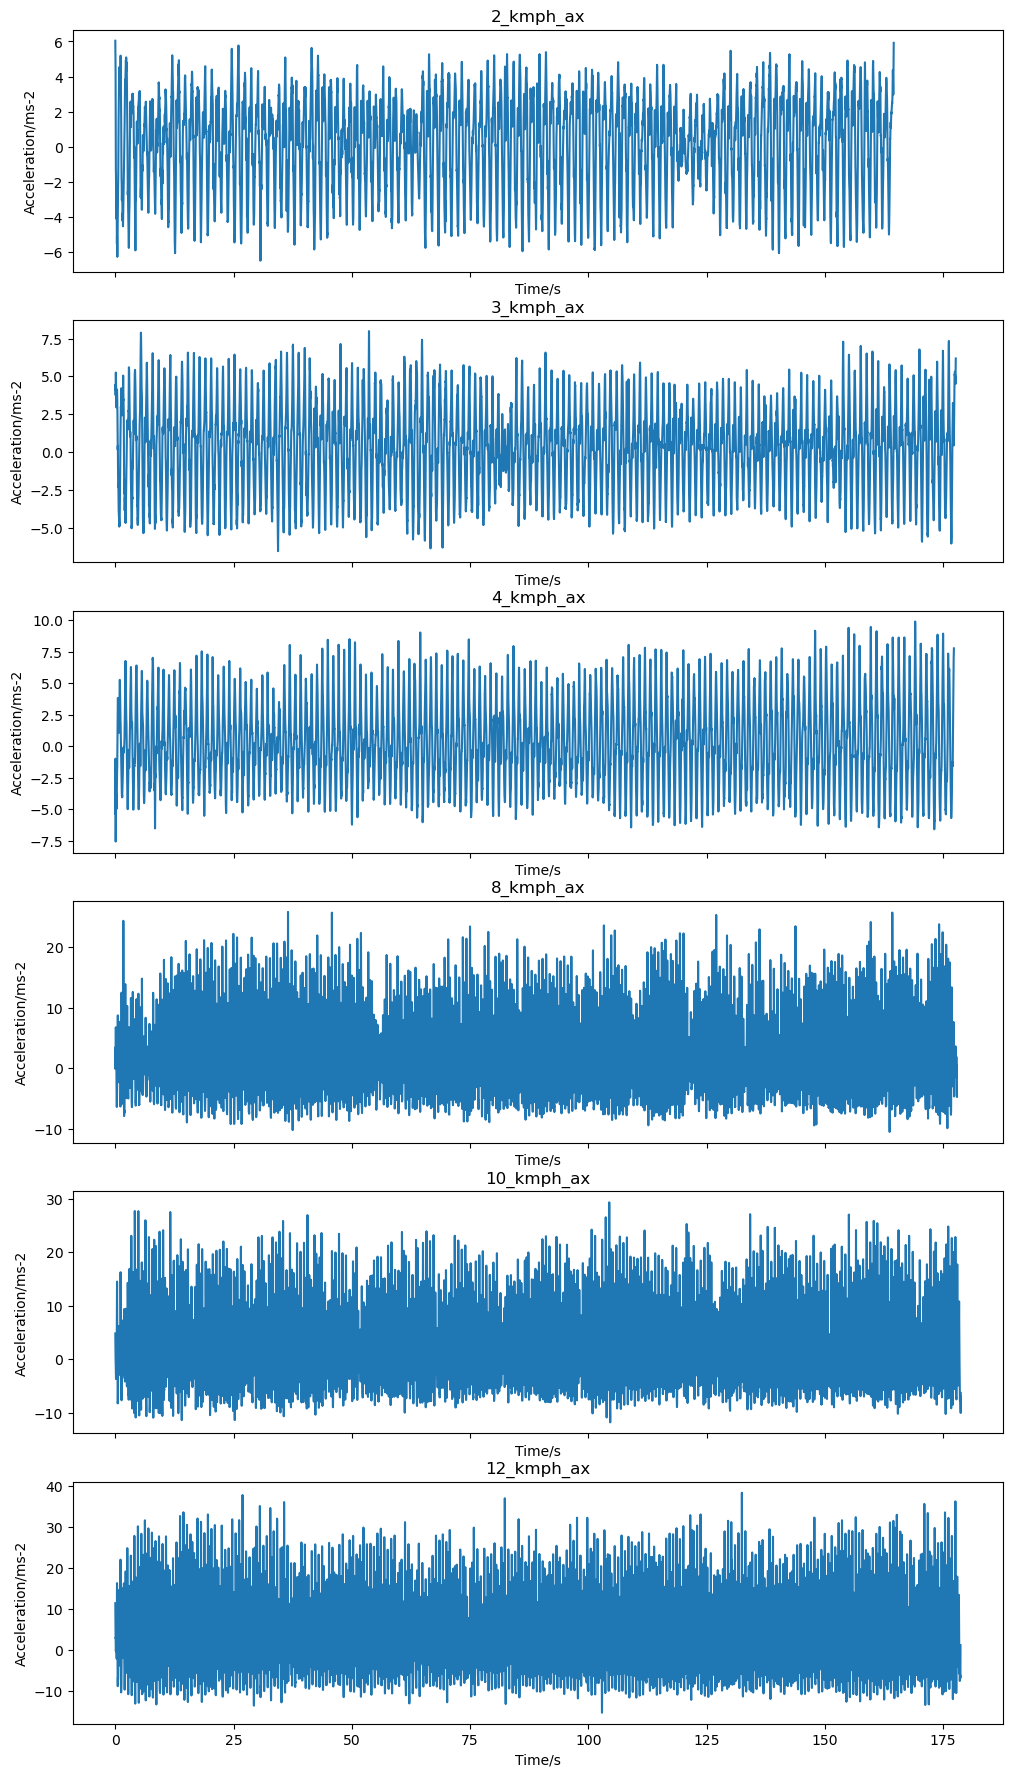

In [85]:
all_speeds_pruned = [pruned_two_kmph_df, pruned_three_kmph_df, pruned_four_kmph_df, pruned_eight_kmph_df, pruned_ten_kmph_df, pruned_twelve_kmph_df]

fig_ax_pruned, ax_x_pruned = plt.subplots(6, sharex=True)
fig_ax_pruned.set_figwidth(12)
fig_ax_pruned.set_figheight(22)

for i in range(len(ax_x)):
    ax_x_pruned[i].set_title(f'{all_names[i]}_ax')
    ax_x_pruned[i].set_xlabel('Time/s')
    ax_x_pruned[i].set_ylabel('Acceleration/ms-2')
    ax_x_pruned[i].plot(all_speeds_pruned[i].index, all_speeds_pruned[i]['ax'])

plt.savefig(fig_dir / 'ax_pruned_fig.png')
plt.show()

### Accelerations in the y-direction after pruning

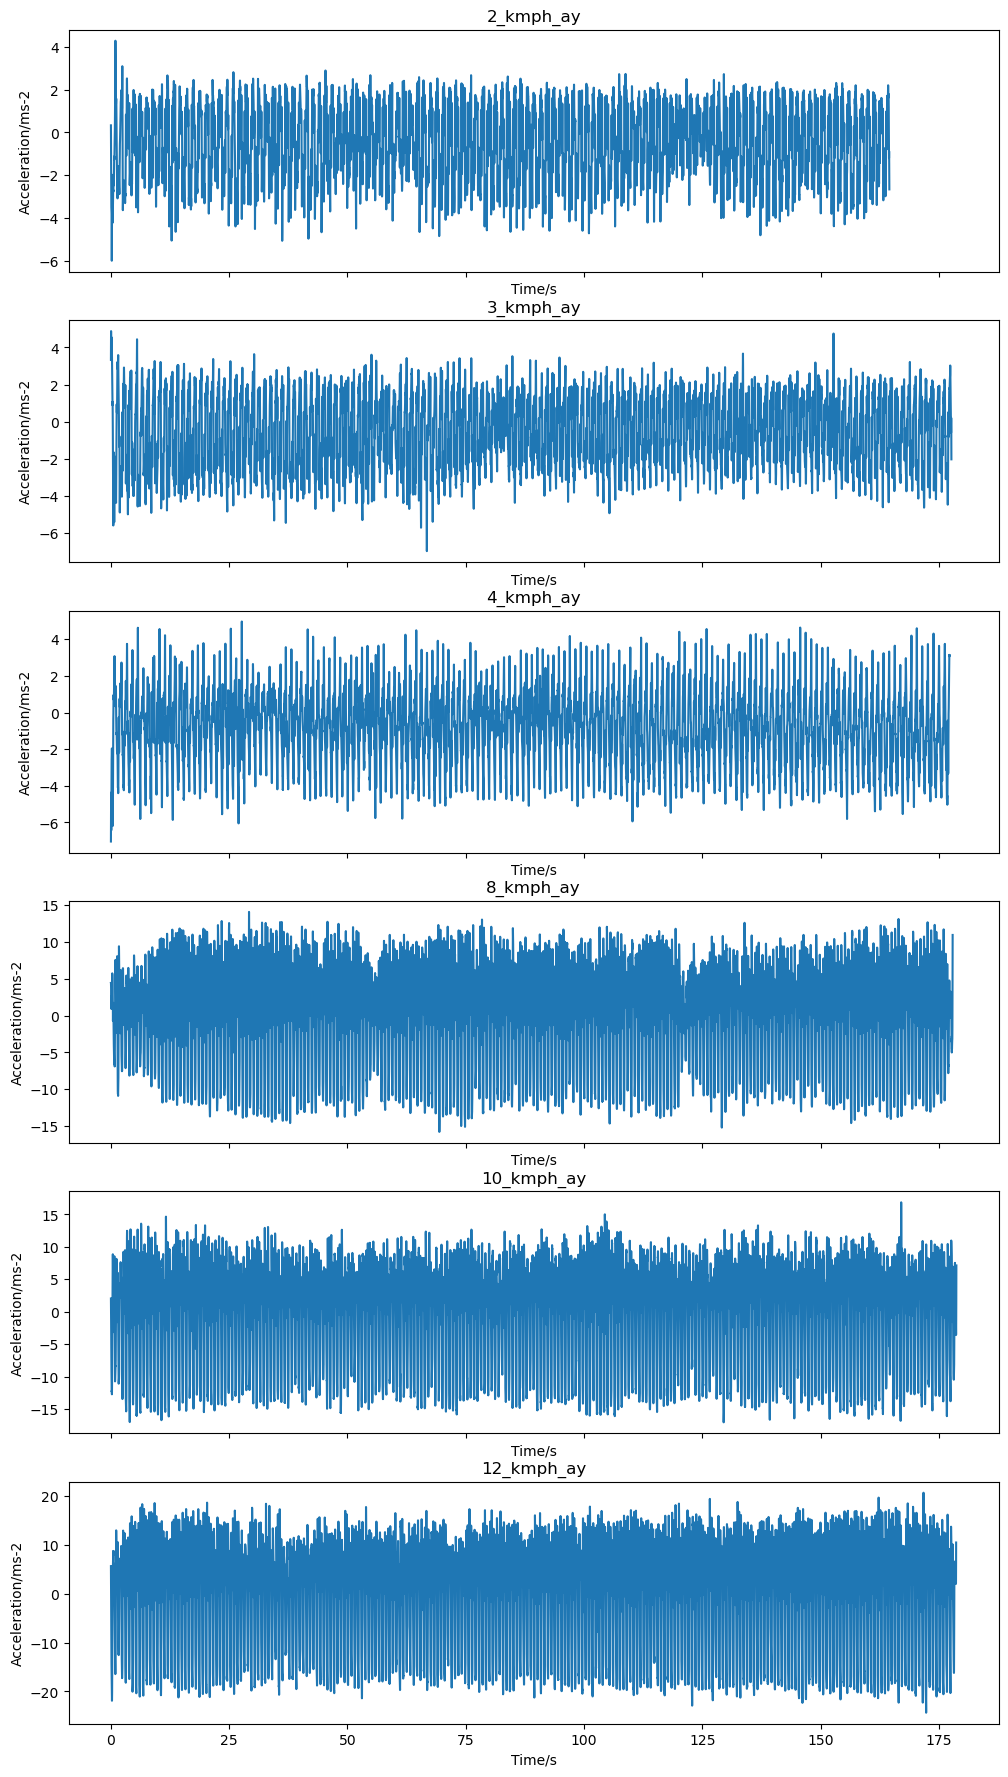

In [86]:
fig_ay_pruned, ax_y_pruned = plt.subplots(6, sharex=True)
fig_ay_pruned.set_figwidth(12)
fig_ay_pruned.set_figheight(22)

for i in range(len(ax_x)):
    ax_y_pruned[i].set_title(f'{all_names[i]}_ay')
    ax_y_pruned[i].set_xlabel('Time/s')
    ax_y_pruned[i].set_ylabel('Acceleration/ms-2')
    ax_y_pruned[i].plot(all_speeds_pruned[i].index, all_speeds_pruned[i]['ay'])

plt.savefig(fig_dir / 'ay_pruned_fig.png')
plt.show()

### Accelerations in the z-direction after pruning

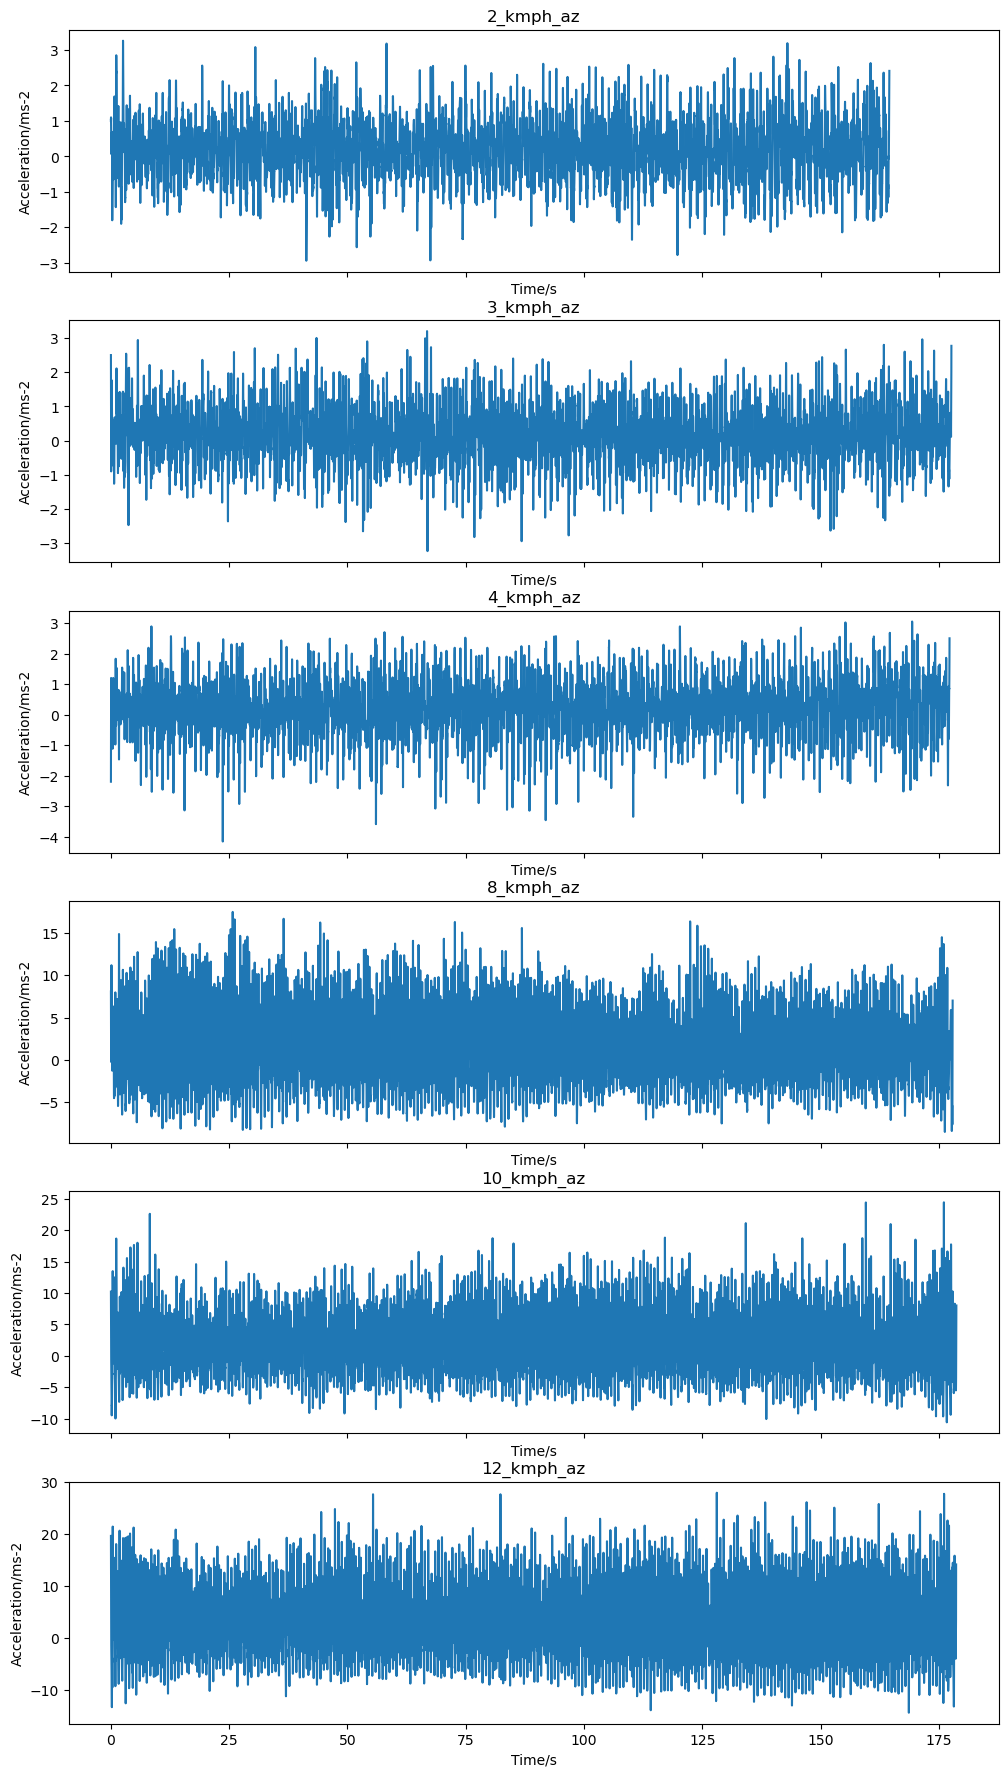

In [87]:
fig_az_pruned, ax_z_pruned = plt.subplots(6, sharex=True)
fig_az_pruned.set_figwidth(12)
fig_az_pruned.set_figheight(22)

for i in range(len(ax_x)):
    ax_z_pruned[i].set_title(f'{all_names[i]}_az')
    ax_z_pruned[i].set_xlabel('Time/s')
    ax_z_pruned[i].set_ylabel('Acceleration/ms-2')
    ax_z_pruned[i].plot(all_speeds_pruned[i].index, all_speeds_pruned[i]['az'])

plt.savefig(fig_dir / 'az_pruned_fig.png')
plt.show()

### Total Accelerations after pruning

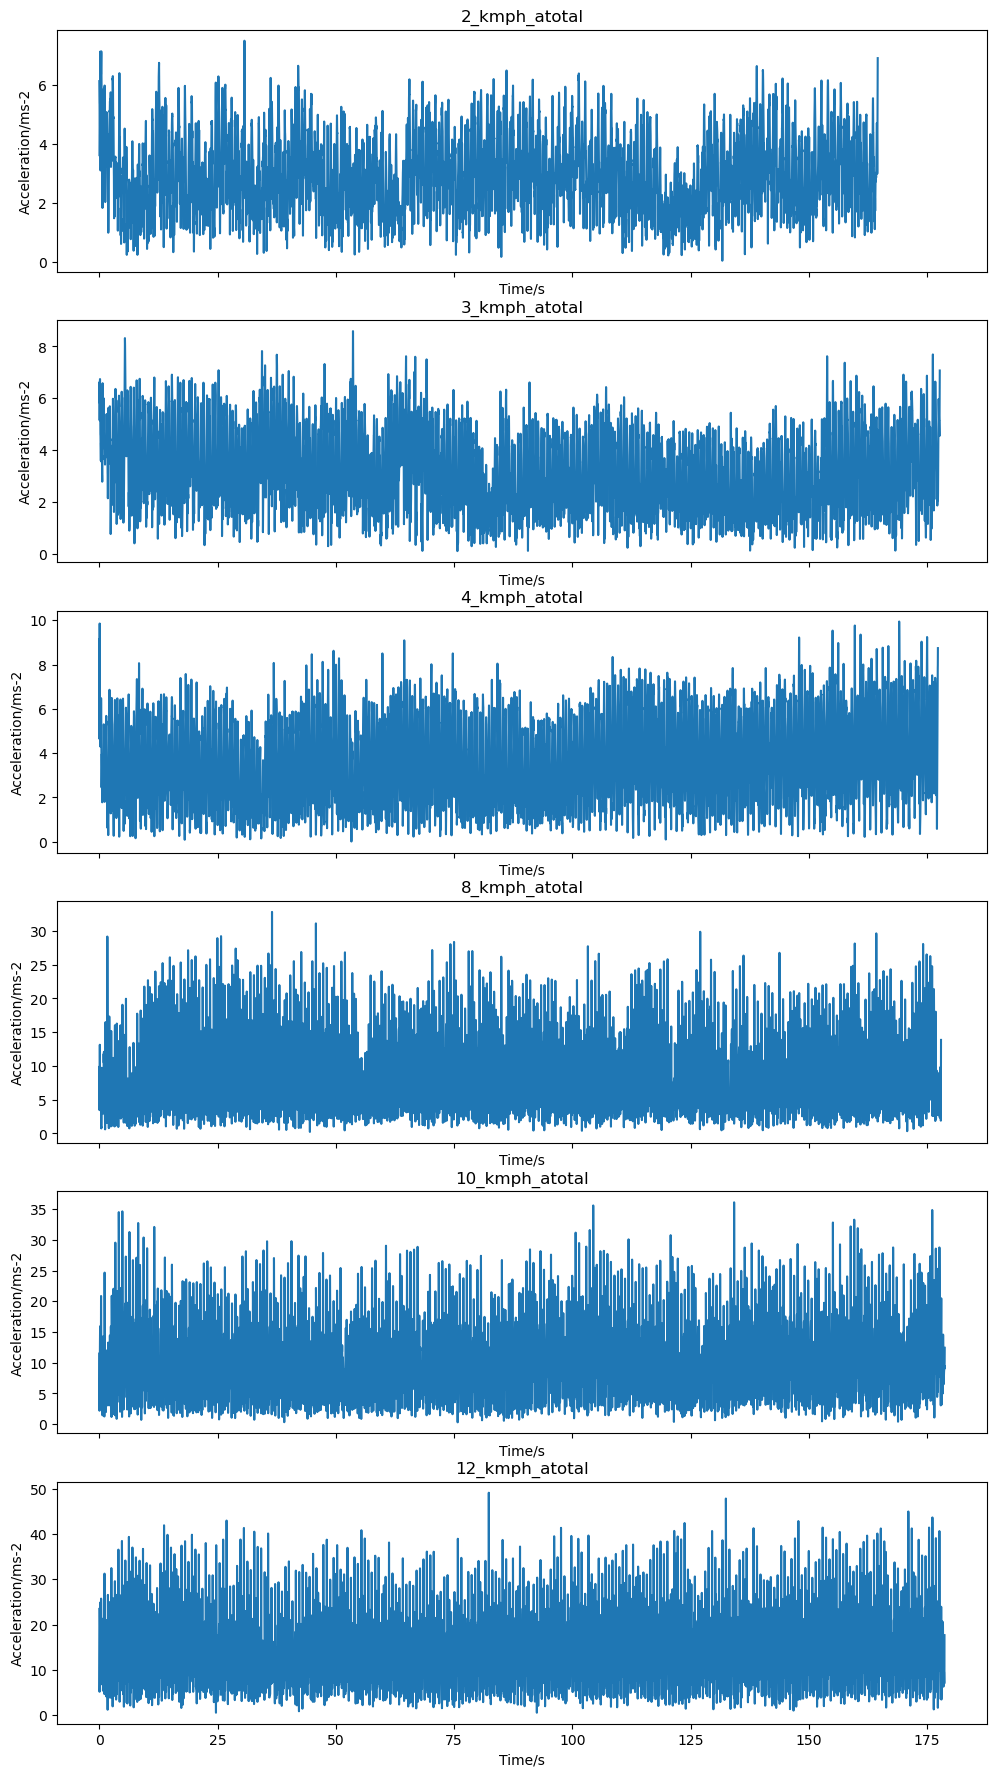

In [88]:
fig_atotal_pruned, ax_total_pruned = plt.subplots(6, sharex=True)
fig_atotal_pruned.set_figwidth(12)
fig_atotal_pruned.set_figheight(22)

for i in range(len(ax_x)):
    ax_total_pruned[i].set_title(f'{all_names[i]}_atotal')
    ax_total_pruned[i].set_xlabel('Time/s')
    ax_total_pruned[i].set_ylabel('Acceleration/ms-2')
    ax_total_pruned[i].plot(all_speeds_pruned[i].index, all_speeds_pruned[i]['atotal'])

plt.savefig(fig_dir / 'atotal_pruned_fig.png')
plt.show()

In [89]:
for i in range(len(all_speeds_pruned)):
    print(f'{all_names[i]} signal length in seconds: {len(all_speeds_pruned[i]) / 100}')

2_kmph signal length in seconds: 164.63
3_kmph signal length in seconds: 177.72
4_kmph signal length in seconds: 177.33
8_kmph signal length in seconds: 177.99
10_kmph signal length in seconds: 178.78
12_kmph signal length in seconds: 178.73


The lengths of each signal are approximately equivalent, so there shouldn't be any concerns with an unbalanced dataset. 

## Extraction of Features

### Window Indexing
'w' will represent walking, and 'r' will represent running in the window indices.

In [90]:
# Creating window indices.
idx_two = np.asarray(np.floor(pruned_two_kmph_df.reset_index().index / 100).values, int)
idx_three = np.asarray(np.floor(pruned_three_kmph_df.reset_index().index / 100).values + idx_two[-1] + 1, int)
idx_four = np.asarray(np.floor(pruned_four_kmph_df.reset_index().index / 100).values + idx_three[-1] + 1, int)

# Prefixing with 'w' which stands for walking. 
pruned_two_kmph_df['window_idx'] = ["w{:03}".format(i) for i in idx_two]
pruned_three_kmph_df['window_idx'] = ["w{:03}".format(i) for i in idx_three]
pruned_four_kmph_df['window_idx'] = ["w{:03}".format(i) for i in idx_four]

pruned_two_kmph_df.to_csv(data_dir / "interim" / "pruned_two_kmph.csv", index=False)
pruned_three_kmph_df.to_csv(data_dir / "interim" / "pruned_three_kmph.csv", index=False)
pruned_four_kmph_df.to_csv(data_dir / "interim" / "pruned_four_kmph.csv", index=False)

pruned_two_kmph_df

ax    ay    az  atotal window_idx
time                                        
0.000    6.04  0.33  1.03    6.14       w000
0.010    5.76 -0.20  0.97    5.84       w000
0.020    5.57 -0.44  1.10    5.69       w000
0.030    5.37 -0.93  0.93    5.53       w000
0.040    5.07 -1.66  0.79    5.39       w000
...       ...   ...   ...     ...        ...
164.505  4.82 -1.04  1.53    5.17       w164
164.515  4.89 -1.50  1.84    5.44       w164
164.525  5.22 -2.11  1.97    5.97       w164
164.535  5.60 -2.39  2.15    6.45       w164
164.545  5.92 -2.66  2.41    6.92       w164

[16463 rows x 5 columns]

In [91]:
idx_eight = np.asarray(np.floor(pruned_eight_kmph_df.reset_index().index / 100).values, int)
idx_ten = np.asarray(np.floor(pruned_ten_kmph_df.reset_index().index / 100).values + idx_eight[-1] + 1, int)
idx_twelve = np.asarray(np.floor(pruned_twelve_kmph_df.reset_index().index  / 100).values + idx_ten[-1] + 1, int)

# Prepend 'r' to window_idx to represent running..
pruned_eight_kmph_df['window_idx'] = ["r{:03}".format(i) for i in idx_eight]
pruned_ten_kmph_df['window_idx'] = ["r{:03}".format(i) for i in idx_ten]
pruned_twelve_kmph_df['window_idx'] = ["r{:03}".format(i) for i in idx_twelve]

pruned_eight_kmph_df.to_csv(data_dir / "interim" / "pruned_eight_kmph.csv", index=False)
pruned_ten_kmph_df.to_csv(data_dir / "interim" / "pruned_ten_kmph.csv", index=False)
pruned_twelve_kmph_df.to_csv(data_dir / "interim" / "pruned_twelve_kmph.csv", index=False)

pruned_eight_kmph_df

ax     ay    az  atotal window_idx
time                                         
0.000    3.40   4.45  8.10    9.85       r000
0.010    1.73   4.43  4.86    6.79       r000
0.020    0.35   4.27  2.24    4.83       r000
0.030   -0.13   3.88  0.81    3.96       r000
0.040    0.36   3.48  0.15    3.50       r000
...       ...    ...   ...     ...        ...
177.885  0.17  -0.11 -1.88    1.89       r177
177.895 -0.76   2.07  3.42    4.07       r177
177.905 -2.55   4.68  5.79    7.87       r177
177.915 -4.01   7.83  6.26   10.79       r177
177.925 -4.73  10.97  7.02   13.86       r177

[17799 rows x 5 columns]

### Concatenating dataframes

In [92]:
walking_df = pd.concat([pruned_two_kmph_df, pruned_three_kmph_df, pruned_four_kmph_df])
walking_df.to_csv(data_dir / "interim" / "walking.csv", index=False)
walking_df

ax    ay    az  atotal window_idx
time                                        
0.000    6.04  0.33  1.03    6.14       w000
0.010    5.76 -0.20  0.97    5.84       w000
0.020    5.57 -0.44  1.10    5.69       w000
0.030    5.37 -0.93  0.93    5.53       w000
0.040    5.07 -1.66  0.79    5.39       w000
...       ...   ...   ...     ...        ...
177.226  7.05  3.15  1.12    7.80       w520
177.236  7.09  3.13  1.33    7.86       w520
177.247  7.18  3.07  1.55    7.96       w520
177.256  7.42  3.08  1.94    8.26       w520
177.266  7.77  3.13  2.50    8.74       w520

[51968 rows x 5 columns]

In [93]:
running_df = pd.concat([pruned_eight_kmph_df, pruned_ten_kmph_df, pruned_twelve_kmph_df])
running_df.to_csv(data_dir / "interim" / "running.csv", index=False)
running_df

ax     ay     az  atotal window_idx
time                                          
0.000    3.40   4.45   8.10    9.85       r000
0.010    1.73   4.43   4.86    6.79       r000
0.020    0.35   4.27   2.24    4.83       r000
0.030   -0.13   3.88   0.81    3.96       r000
0.040    0.36   3.48   0.15    3.50       r000
...       ...    ...    ...     ...        ...
178.622 -6.79   2.00   0.80    7.12       r535
178.632 -6.79   2.23   1.78    7.37       r535
178.642 -6.68   3.70   3.64    8.46       r535
178.652 -4.83   6.53   7.26   10.90       r535
178.662  1.25  10.46  14.18   17.67       r535

[53550 rows x 5 columns]

There are 51968 rows combined in the walking dataframe, and 53550 rows combined in the running dataframe.

In [94]:
walking_running_df = pd.concat([walking_df, running_df])
walking_running_df.to_csv(data_dir / "interim" / "walking_running.csv", index=False)
walking_running_df

ax     ay     az  atotal window_idx
time                                          
0.000    6.04   0.33   1.03    6.14       w000
0.010    5.76  -0.20   0.97    5.84       w000
0.020    5.57  -0.44   1.10    5.69       w000
0.030    5.37  -0.93   0.93    5.53       w000
0.040    5.07  -1.66   0.79    5.39       w000
...       ...    ...    ...     ...        ...
178.622 -6.79   2.00   0.80    7.12       r535
178.632 -6.79   2.23   1.78    7.37       r535
178.642 -6.68   3.70   3.64    8.46       r535
178.652 -4.83   6.53   7.26   10.90       r535
178.662  1.25  10.46  14.18   17.67       r535

[105518 rows x 5 columns]

The combined walking and running dataframes have 105518 rows in total.

In [95]:
walking_running_df['window_idx'].nunique()

1057

There are 1057 unique window indices.

### Extraction of Features

In [96]:
extracted_features = extract_features(walking_running_df, column_id='window_idx')

Feature Extraction: 100%|██████████| 20/20 [02:04<00:00,  6.23s/it]


In [114]:
impute(extracted_features) # Impute NA/null values.
extracted_features.to_csv(data_dir / "interim" / "extracted_features.csv", index=False)
extracted_features

ax__variance_larger_than_standard_deviation  ax__has_duplicate_max  \
r000                                          1.0                    0.0   
r001                                          1.0                    0.0   
r002                                          1.0                    0.0   
r003                                          1.0                    0.0   
r004                                          1.0                    0.0   
...                                           ...                    ...   
w516                                          1.0                    1.0   
w517                                          1.0                    0.0   
w518                                          1.0                    0.0   
w519                                          1.0                    0.0   
w520                                          1.0                    0.0   

      ax__has_duplicate_min  ax__has_duplicate  ax__sum_values  \
r000                    0.0                1.0           86.13   
r001                    0.0                1.0          -66.64   
r002                    0.0                1.0           72.64   
r003                    0.0                1.0            1.78   
r004                    0.0                1.0           70.12   
...                     ...                ...             ...   
w516                    0.0                1.0           24.00   
w517                    0.0                1.0          -58.68   
w518                    0.0                1.0          -27.39   
w519                    0.0                1.0           93.73   
w520                    0.0                1.0           85.86   

      ax__abs_energy  ax__mean_abs_change  ax__mean_change  \
r000       1655.8011             0.681111         0.039495   
r001       5067.8256             1.277879        -0.083131   
r002       2051.5922             0.859192         0.020808   
r003       1935.8234             0.776869         0.003535   
r004       2665.7300             0.916970        -0.037980   
...              ...                  ...              ...   
w516       2248.3118             0.261414         0.059394   
w517       1452.6522             0.245455         0.040808   
w518       1695.3341             0.216364        -0.085051   
w519       2043.0013             0.261414        -0.022020   
w520        586.0924             0.308750         0.290625   

      ax__mean_second_derivative_central  ax__median  ...  \
r000                            0.006633      -0.075  ...   
r001                            0.016633      -2.755  ...   
r002                           -0.011020       0.115  ...   
r003                            0.003214      -0.855  ...   
r004                           -0.003929      -0.940  ...   
...                                  ...         ...  ...   
w516                            0.000816      -0.530  ...   
w517                            0.003776      -1.650  ...   
w518                            0.000765      -1.705  ...   
w519                           -0.002653       1.225  ...   
w520                            0.002097       2.210  ...   

      atotal__fourier_entropy__bins_5  atotal__fourier_entropy__bins_10  \
r000                         0.575228                          0.706253   
r001                         0.369812                          0.508382   
r002                         0.481199                          0.668811   
r003                         0.413917                          0.508382   
r004                         0.464277                          0.518641   
...                               ...                               ...   
w516                         0.288342                          0.288342   
w517                         0.165443                          0.165443   
w518                         0.288342                          0.288342   
w519                         0.288342                          0.288342 

The resulting feature matrix has 1057 rows and 3132 columns. In other words, 3132 features have been extracted over 1057 windows.

## Activity Recognition Model

Denote running as true and walking as false.

In [98]:
target = pd.Series(extracted_features.index.str[0] == 'r', index=extracted_features.index)
target


r000     True
r001     True
r002     True
r003     True
r004     True
        ...  
w516    False
w517    False
w518    False
w519    False
w520    False
Length: 1057, dtype: bool

### Feature Selection

In [99]:
select = FeatureSelector()
select.fit(extracted_features, target)

FeatureSelector()

### Feature Reduction

In [100]:
select.transform(extracted_features)

az__variance_larger_than_standard_deviation  \
r000                                          1.0   
r001                                          1.0   
r002                                          1.0   
r003                                          1.0   
r004                                          1.0   
...                                           ...   
w516                                          0.0   
w517                                          0.0   
w518                                          0.0   
w519                                          0.0   
w520                                          0.0   

      ax__number_crossing_m__m_-1  \
r000                          6.0   
r001                          7.0   
r002                          5.0   
r003                          6.0   
r004                          5.0   
...                           ...   
w516                          1.0   
w517                          2.0   
w518                          2.0   
w519                          1.0   
w520                          1.0   

      az__ratio_value_number_to_time_series_length  az__absolute_maximum  \
r000                                      0.940000                 11.20   
r001                                      0.990000                 14.89   
r002                                      0.950000                 10.66   
r003                                      0.970000                 10.30   
r004                                      0.960000                 12.20   
...                                            ...                   ...   
w516                                      0.840000                  2.00   
w517                                      0.880000                  2.35   
w518                                      0.810000                  1.64   
w519                                      0.720000                  2.32   
w520                                      0.939394                  2.50   

      az__maximum  ay__maximum  atotal__maximum  atotal__absolute_maximum  \
r000        11.20         7.58            13.14                     13.14   
r001        14.89         9.43            29.18                     29.18   
r002        10.66         6.44            17.33                     17.33   
r003        10.30         6.49            16.28                     16.28   
r004        12.20         8.19            19.07                     19.07   
...           ...          ...              ...                       ...   
w516         1.57         4.31             9.03                      9.03   
w517         2.35         1.36             8.35                      8.35   
w518         1.64         3.64             9.24                      9.24   
w519         1.86         3.75             7.51                      7.51   
w520         2.50         3.15             8.74                      8.74   

      az__quantile__q_0.8  az__quantile__q_0.1  ...  \
r000                5.762               -3.880  ...   
r001                3.218               -3.976  ...   
r002                5.576               -4.829  ...   
r003                2.810               -5.117  ...   
r004                6.310               -4.689  ...   
...                   ...                  ...  ...   
w516                1.060               -1.020  ...   
w517                1.244               -0.946  ...   
w518                0.896               -0.740  ...   
w519                1.010               -0.250  ...   
w520                0.900               -0.796  ...   

      atotal__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)  \
r000                                          -6.353659               
r001                                           1.133600               
r002                                           0.461592               
r003                                           1.495860               
r004                                          -1.133400               

In [101]:
p_values_top5 = select.p_values[:5]
p_values_top5

array([5.00047690e-238, 2.38755945e-177, 2.74217433e-174, 3.20327653e-174,
       3.20534176e-174])

In [102]:
relevant_features_top5 = select.relevant_features[:5]
relevant_features_top5

['az__variance_larger_than_standard_deviation',
 'ax__number_crossing_m__m_-1',
 'az__ratio_value_number_to_time_series_length',
 'az__absolute_maximum',
 'az__maximum']

### 5 Features with the smallest p-values

In [103]:
relevant_feats_p_value_top5 = pd.DataFrame({"Feature": relevant_features_top5, "p-values": p_values_top5})
relevant_feats_p_value_top5.to_csv(data_dir / "interim" / "relevant_feats_p_value_top5.csv", index=False)
relevant_feats_p_value_top5

Feature       p-values
0   az__variance_larger_than_standard_deviation  5.000477e-238
1                   ax__number_crossing_m__m_-1  2.387559e-177
2  az__ratio_value_number_to_time_series_length  2.742174e-174
3                          az__absolute_maximum  3.203277e-174
4                                   az__maximum  3.205342e-174

In [ ]:
relevant_features_top5_df = pd.concat([extracted_features[relevant_features_top5], pd.DataFrame(target, columns=["target"])], axis=1)
relevant_features_top5_df

az__variance_larger_than_standard_deviation  \
r000                                          1.0   
r001                                          1.0   
r002                                          1.0   
r003                                          1.0   
r004                                          1.0   
...                                           ...   
w516                                          0.0   
w517                                          0.0   
w518                                          0.0   
w519                                          0.0   
w520                                          0.0   

      ax__number_crossing_m__m_-1  \
r000                          6.0   
r001                          7.0   
r002                          5.0   
r003                          6.0   
r004                          5.0   
...                           ...   
w516                          1.0   
w517                          2.0   
w518                          2.0   
w519                          1.0   
w520                          1.0   

      az__ratio_value_number_to_time_series_length  az__absolute_maximum  \
r000                                      0.940000                 11.20   
r001                                      0.990000                 14.89   
r002                                      0.950000                 10.66   
r003                                      0.970000                 10.30   
r004                                      0.960000                 12.20   
...                                            ...                   ...   
w516                                      0.840000                  2.00   
w517                                      0.880000                  2.35   
w518                                      0.810000                  1.64   
w519                                      0.720000                  2.32   
w520                                      0.939394                  2.50   

      az__maximum  target  
r000        11.20    True  
r001        14.89    True  
r002        10.66    True  
r003        10.30    True  
r004        12.20    True  
...           ...     ...  
w516         1.57   False  
w517         2.35   False  
w518         1.64   False  
w519         1.86   False  
w520         2.50   False  

[1057 rows x 6 columns]

### Visualisation of the 5 Features with the smallest p-value

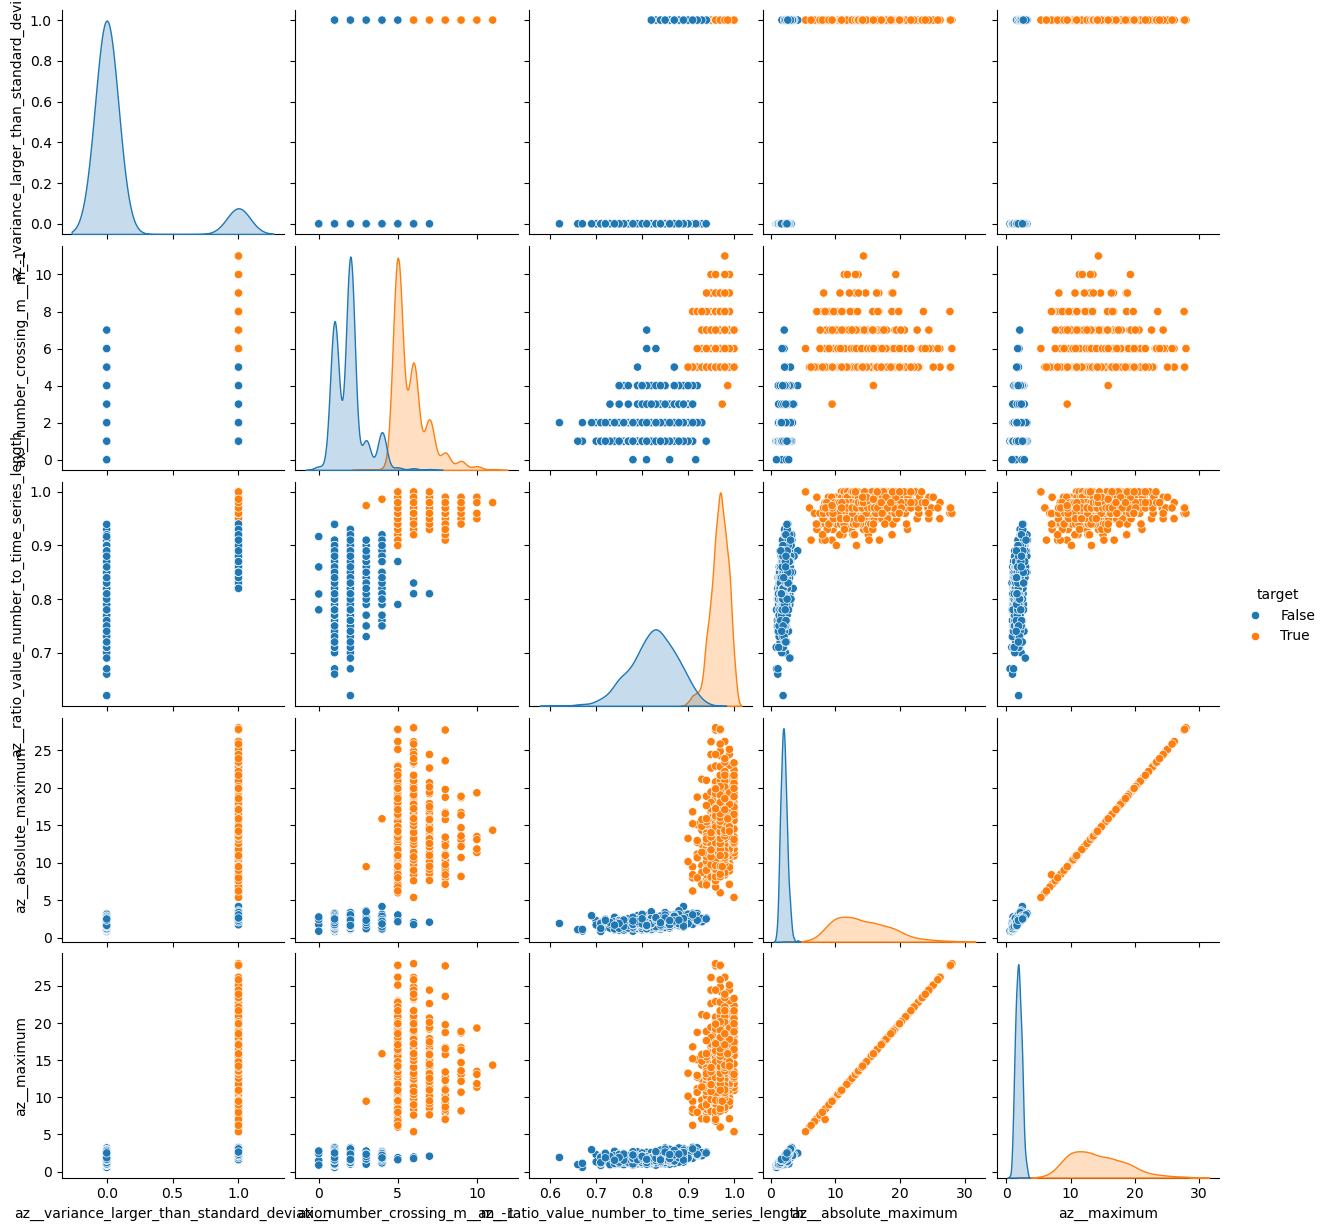

In [105]:
sns.pairplot(relevant_features_top5_df, hue='target')
plt.savefig(fig_dir / 'five_smallest_p_value_pairplot_fig.png')
plt.show()

The distributions on the diagonal entries of the figure show that these features are good choices for classifying between walking and running due to the lack of overlap. This is further supported by the scatter plots, which also illustrate little to no overlap

In [106]:
all_relevant_features_df = extracted_features[select.relevant_features]
all_relevant_features_df.to_csv(data_dir / "interim" / "all_relevant_features.csv", index=False)
all_relevant_features_df

az__variance_larger_than_standard_deviation  \
r000                                          1.0   
r001                                          1.0   
r002                                          1.0   
r003                                          1.0   
r004                                          1.0   
...                                           ...   
w516                                          0.0   
w517                                          0.0   
w518                                          0.0   
w519                                          0.0   
w520                                          0.0   

      ax__number_crossing_m__m_-1  \
r000                          6.0   
r001                          7.0   
r002                          5.0   
r003                          6.0   
r004                          5.0   
...                           ...   
w516                          1.0   
w517                          2.0   
w518                          2.0   
w519                          1.0   
w520                          1.0   

      az__ratio_value_number_to_time_series_length  az__absolute_maximum  \
r000                                      0.940000                 11.20   
r001                                      0.990000                 14.89   
r002                                      0.950000                 10.66   
r003                                      0.970000                 10.30   
r004                                      0.960000                 12.20   
...                                            ...                   ...   
w516                                      0.840000                  2.00   
w517                                      0.880000                  2.35   
w518                                      0.810000                  1.64   
w519                                      0.720000                  2.32   
w520                                      0.939394                  2.50   

      az__maximum  ay__maximum  atotal__maximum  atotal__absolute_maximum  \
r000        11.20         7.58            13.14                     13.14   
r001        14.89         9.43            29.18                     29.18   
r002        10.66         6.44            17.33                     17.33   
r003        10.30         6.49            16.28                     16.28   
r004        12.20         8.19            19.07                     19.07   
...           ...          ...              ...                       ...   
w516         1.57         4.31             9.03                      9.03   
w517         2.35         1.36             8.35                      8.35   
w518         1.64         3.64             9.24                      9.24   
w519         1.86         3.75             7.51                      7.51   
w520         2.50         3.15             8.74                      8.74   

      az__quantile__q_0.8  az__quantile__q_0.1  ...  \
r000                5.762               -3.880  ...   
r001                3.218               -3.976  ...   
r002                5.576               -4.829  ...   
r003                2.810               -5.117  ...   
r004                6.310               -4.689  ...   
...                   ...                  ...  ...   
w516                1.060               -1.020  ...   
w517                1.244               -0.946  ...   
w518                0.896               -0.740  ...   
w519                1.010               -0.250  ...   
w520                0.900               -0.796  ...   

      atotal__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)  \
r000                                          -6.353659               
r001                                           1.133600               
r002                                           0.461592               
r003                                           1.495860               
r004                                          -1.133400               

### Fitting Random Forest Classifier and cross-validation

In [107]:
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42) # Perform 10-fold cv 10 times.

clf = RandomForestClassifier()
scores = cross_val_score(clf, all_relevant_features_df, target, cv=cv)

In [108]:
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The scores array indicates that all 100 training and testing folds from the 10-times repeated 10-fold cross-validation achieved 100% prediction accuracy.

### Fitting on all data

In [109]:
clf2 = RandomForestClassifier()
clf2.fit(all_relevant_features_df, target)

with open(model_dir / 'final_model.pkl','wb') as f:
    pickle.dump(clf, f)

In [110]:
importances = clf2.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_relevant_features_df.columns,
    'Importance': importances
})

feature_importance_df

Feature  Importance
0        az__variance_larger_than_standard_deviation        0.00
1                        ax__number_crossing_m__m_-1        0.00
2       az__ratio_value_number_to_time_series_length        0.00
3                               az__absolute_maximum        0.03
4                                        az__maximum        0.00
...                                              ...         ...
1197           atotal__ar_coefficient__coeff_9__k_10        0.00
1198  ax__friedrich_coefficients__coeff_0__m_3__r_30        0.00
1199     az__fft_coefficient__attr_"angle"__coeff_43        0.00
1200      ax__fft_coefficient__attr_"angle"__coeff_1        0.00
1201                           ay__has_duplicate_max        0.00

[1202 rows x 2 columns]

### 5 Most Important Features Identified by feature_importances_

In [111]:
feature_importance_sorted_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_sorted_df.to_csv(data_dir / "interim" / "feature_importance_sorted.csv", index=False)
feature_importance_sorted_df.head(5)

Feature  Importance
111  atotal__change_quantiles__f_agg_"var"__isabs_T...        0.07
65   ax__change_quantiles__f_agg_"var"__isabs_True_...        0.04
14   ax__change_quantiles__f_agg_"mean"__isabs_True...        0.03
27   atotal__change_quantiles__f_agg_"mean"__isabs_...        0.03
3                                 az__absolute_maximum        0.03

The 5 most important features:
- change_quantiles (atotal, ax, ax, atotal): Finds points in the time series less than ql and greater than qh, and computes the difference between adjacent values (absolute diference if isabs=True) that fall outside this corridor, then aggregates using the function defined for the f_agg parameter.
- maximum (az): The absolute maximum value of the time series.

In [112]:
all_relevant_features_with_labels = pd.concat([extracted_features[feature_importance_sorted_df['Feature'].iloc[:5]], pd.DataFrame(target, columns=['target'])], axis=1)
all_relevant_features_with_labels.to_csv(data_dir / "processed" / "all_relevant_features_with_labels.csv", index=False)
all_relevant_features_with_labels

atotal__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0  \
r000                                           0.398618                   
r001                                           0.913306                   
r002                                           0.506248                   
r003                                           0.497177                   
r004                                           0.544153                   
...                                                 ...                   
w516                                           0.047892                   
w517                                           0.019968                   
w518                                           0.018304                   
w519                                           0.069663                   
w520                                           0.038102                   

      ax__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0  \
r000                                           0.255426               
r001                                           1.991750               
r002                                           0.774904               
r003                                           0.762527               
r004                                           0.565282               
...                                                 ...               
w516                                           0.022006               
w517                                           0.021154               
w518                                           0.021092               
w519                                           0.049792               
w520                                           0.028880               

      ax__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0  \
r000                                           0.681111                
r001                                           1.277879                
r002                                           0.859192                
r003                                           0.776869                
r004                                           0.916970                
...                                                 ...                
w516                                           0.261414                
w517                                           0.245455                
w518                                           0.216364                
w519                                           0.261414                
w520                                           0.308750                

      atotal__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0  \
r000                                           0.812642                    
r001                                           0.942778                    
r002                                           0.862727                    
r003                                           0.850545                    
r004                                           0.819091                    
...                                                 ...                    
w516                                           0.334737                    
w517                                           0.209310                    
w518                                           0.163860                    
w519                                           0.291636                    
w520                                           0.352105                    

      az__absolute_maximum  target  
r000                 11.20    True  
r001                 14.89    True  
r002                 10.66    True  
r003                 10.30    True  
r004                 12.20    True  
...                    ...     ...  
w516                  2.00   False  
w517                  2.35   False  
w518                  1.64   False  
w519                  2.32   False  
w520                  2.50   False  

[1057 rows x 6 columns]

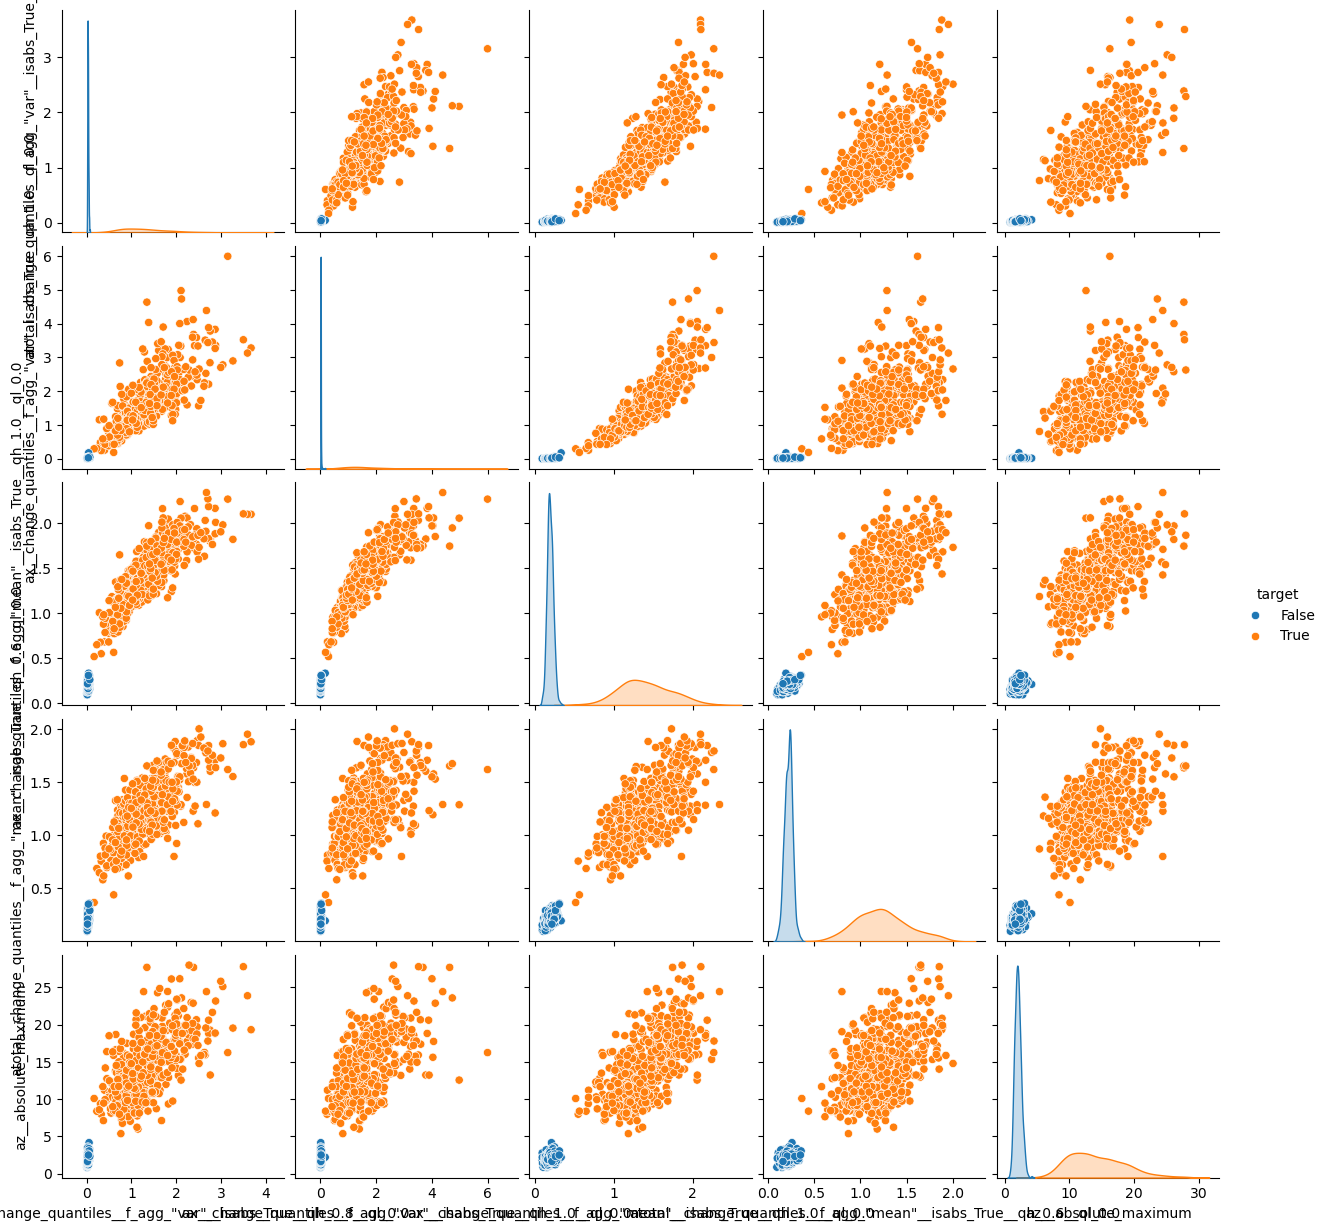

In [113]:
sns.pairplot(all_relevant_features_with_labels, hue='target')
plt.savefig(fig_dir / 'five_most_important_feats_pairplot_fig.png')
plt.show()

When comparing the walking and running distributions, the difference is quite apparent. There is essentially no overlap between the two distributions on the diagonal entries, which makes these excellent features for classification. This is further supported by the scatter plots, which also show a clear separation between walking and running activities.